Retrieve processed data from GitHub

In [ ]:
import requests
import io
import csv
import torch
import torchtext


def get_sentences():
    processed = [[], [], []]
    urls = []
    urls.append("https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/trainEncoded")
    urls.append("https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/validEncoded")
    urls.append("https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/testEncoded")
    raws = [requests.get(u).text for u in urls]
    separated = [csv.reader(io.StringIO(r)) for r in raws]
    for i in range(len(separated)):
      for row in separated[i]:
        idxs = row[2][1:-1].split(", ")
        if idxs[0] == "": continue
        idxs = list(map(int, idxs))
        idxs = [id % 10000 for id in idxs]
        idxs = torch.tensor(idxs)
        label = torch.tensor(int(row[1] == "[5721]")).long()
        processed[i].append((idxs, label))

    return processed[0], processed[1], processed[2] # Train, valid, test as [(tensor([idx]), tensor(label))]

In [ ]:
import torch.nn as nn


class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove):
        super(LSTMNet, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Really should be true size of x.size(1) - 1
        return out

In [ ]:
import random


class Batcher:
    def __init__(self, sentences, batch_size=32, drop_last=False):
        self.sentences_by_length = {}
        for sentence, label in sentences:
            len = sentence.size(0)
            if len not in self.sentences_by_length:
                self.sentences_by_length[len] = []

            self.sentences_by_length[len].append((sentence, label))

        self.loaders = {len : torch.utils.data.DataLoader(
                                    sentences,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last)
            for len, sentences in self.sentences_by_length.items()}

    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)

            except StopIteration:
                iters.remove(im)

In [ ]:
def get_accuracy(model, loader):
    correct, total = 0, 0
    for sentences, labels in loader:
        output = model(sentences)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.size(0)

    return correct / total

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt


def train_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc =[], [], []
    for epoch in range(num_epochs):
        for sentences, labels in train:
            optimizer.zero_grad()
            pred = model(sentences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch, loss, train_acc[-1], valid_acc[-1]))

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
#import torch.nn.functional as F
#import numpy as np

Epoch 0; Loss 0.689268; Train Acc 0.555859; Val Acc 0.558223
Epoch 1; Loss 0.674495; Train Acc 0.745313; Val Acc 0.715486
Epoch 2; Loss 0.655436; Train Acc 0.848437; Val Acc 0.780312
Epoch 3; Loss 0.643379; Train Acc 0.883984; Val Acc 0.806723
Epoch 4; Loss 0.608731; Train Acc 0.918750; Val Acc 0.829532
Epoch 5; Loss 0.586220; Train Acc 0.937891; Val Acc 0.839136
Epoch 6; Loss 0.572918; Train Acc 0.941797; Val Acc 0.845138
Epoch 7; Loss 0.549296; Train Acc 0.945703; Val Acc 0.848739
Epoch 8; Loss 0.552075; Train Acc 0.948828; Val Acc 0.849940
Epoch 9; Loss 0.536203; Train Acc 0.952734; Val Acc 0.852341
Epoch 10; Loss 0.510840; Train Acc 0.952734; Val Acc 0.852341
Epoch 11; Loss 0.522791; Train Acc 0.955859; Val Acc 0.852341
Epoch 12; Loss 0.540785; Train Acc 0.953516; Val Acc 0.852341
Epoch 13; Loss 0.400590; Train Acc 0.955859; Val Acc 0.852341
Epoch 14; Loss 0.408023; Train Acc 0.955469; Val Acc 0.852341
Epoch 15; Loss 0.386655; Train Acc 0.955078; Val Acc 0.853541
Epoch 16; Loss 0.3

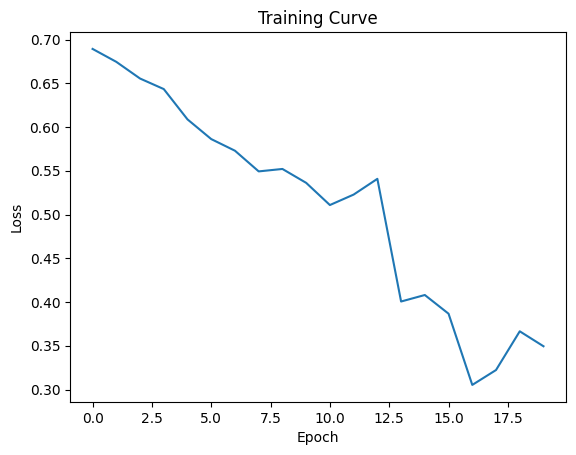

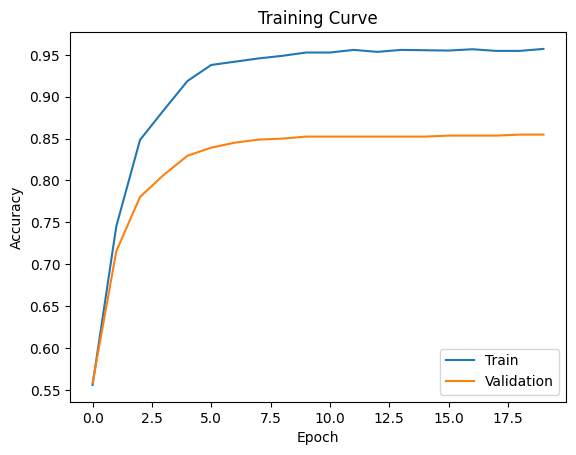

0.8540410132689988

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)

model = LSTMNet(50, 50, 2, glove)

train, valid, test = get_sentences()

train_loader = Batcher(train, batch_size=64, drop_last=True)
valid_loader = Batcher(valid, batch_size=64, drop_last=False)
test_loader = Batcher(test, batch_size=64, drop_last=False)

train_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)

get_accuracy(model, test_loader)